In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
import numpy as np

from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout


In [2]:
import os
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image


In [9]:
import os 
import tensorflow as tf
from tensorflow.keras import preprocessing, optimizers, losses,metrics
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


In [12]:
def load_image(path, labels):
    ims, labs = [], []
    for file in os.listdir(path):
        #print(file)
        if (file.endswith(".jpg")) or (file.endswith("png")):
            img = image.load_img(os.path.join(path, file), target_size=(224, 244,3))
            #print(img)
            
            ims.append(image.img_to_array(img))
            labs.append(labels)
    return ims, labs
    

In [13]:
ims, labs = load_image('./flower_images/Lilly', 0)


In [14]:
ims = np.asarray(ims)/255

In [18]:
def show_images(example, n):
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(example[i])
  pyplot.show()

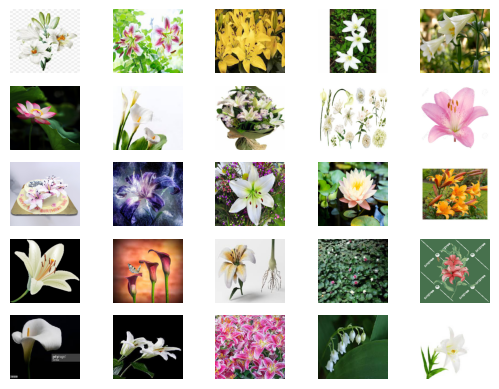

In [19]:
example = ims[np.random.choice(ims.shape[0], size=28, replace=False)]
show_images(example, 5)

In [20]:
def discriminator(in_shape=(28,28,3)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])
  return model

In [21]:
def generator(latent_dim):
  model = Sequential()
  n_nodes = 128*7*7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
  return model

In [22]:
def combine(generator, discriminator):
  model = Sequential()
  model.add(generator)

  model.add(discriminator)
  model.compile(loss='binary_crossentropy', optimizer="Adam")
  return model

In [23]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [24]:
def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(x_input)
  y = zeros((n_samples, 1))
  return X, y

In [25]:
import matplotlib.pyplot as plt
def save_plot(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0])
  plt.show()

In [26]:
def sumarise_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  print(epoch, acc_real, acc_fake)
  save_plot(x_fake, epoch)

In [27]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epoch = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epoch):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      X, y = vstack((X_real, x_fake)), vstack((y_real, y_fake))
      d_loss, _ = discriminator.train_on_batch(X, y)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan.train_on_batch(X_gan, y_gan)
      if (j+1) % 100 == 0:
        print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epoch, d_loss, g_loss))
        sumarise_performance(i, generator, discriminator, dataset, latent_dim)

In [29]:
def genereate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  return X, y
from tensorflow.keras.models import load_model
from numpy.random import randn

from matplotlib import pyplot
import h5py
model = load_model('generator_model_050.h5', compile=False)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [30]:
latent_dim = 100
discriminator_model = discriminator()
generator_model = generator(latent_dim)
gan_model = combine(generator_model, discriminator_model)

print(discriminator_model.summary())
print(generator_model.summary())
print(gan_model.summary())
#train(generator_model, discriminator_model, gan_model, data, latent_dim)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         3,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,857 (163.50 KB)

 Trainable params: 41,857 (163.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,164,289 (4.44 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │     1,164,289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │        41,857 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,146 (4.60 MB)

 Trainable params: 1,206,146 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

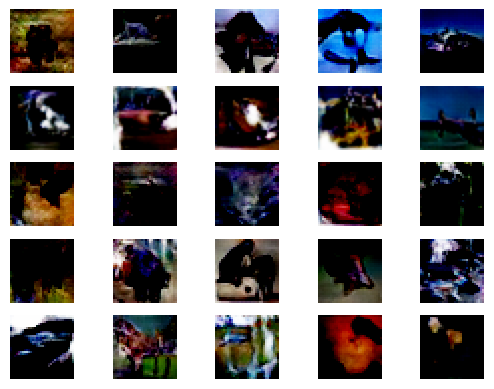

In [38]:

# load model after 10 epoch
model = load_model('generator_model_050.h5', compile=False)

# generate images
latent_points = generate_latent_points(latent_dim,25)
input_tensor = tf.random.normal((25, 100))

# Reshape it to (25, 1, 100) or (batch_size, sequence_length, 100)
reshaped_input = tf.expand_dims(input_tensor, axis=1)
#print(latent_points)
#model.add(tensorflow.keras.layers.Dense(0, input_shape=(dataset.shape[1],), activation='sigmoid'))
# generate images
X = model.predict(reshaped_input)
# plot the result
show_images(X, 5)

#Run the above cole multiple times to see different images being generated.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

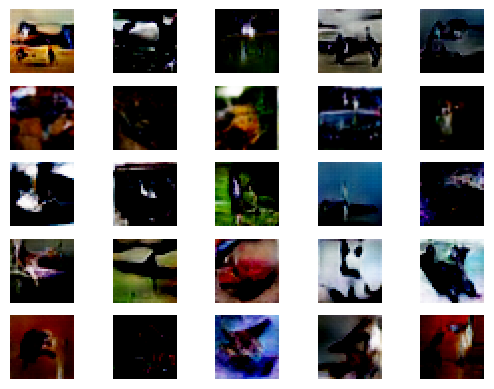

In [40]:
# load model after 100 epoch
model = load_model('generator_model_050.h5', compile=False)


# Reshape it to (25, 1, 100) or (batch_size, sequence_length, 100)


# generate images
latent_points = generate_latent_points(latent_dim, 25)
reshaped_input = tf.expand_dims(latent_points, 1)
# generate images
X = model.predict(reshaped_input)
# plot the result
show_images(X, 5)